In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import inaugural, stopwords, wordnet
import nltk
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import cluster

# Goal

* __attempt to classify which president gave their inaugural address__
* reserve 25% as a holdout group to test on
* Create clusters for each author
    
      * Try multiple techniques
      
* Do unsupervised feature generation and selection (us tf_idf and LSA)

* Try different supervised and unsupervised techniques to classify as best as possible (gradient boosting, logistic regression, SVC, random forest)

* test model on holdout group. Is it consistent?

* Do a report on the pros and cons of one technique over another and why decision were made

In [2]:
inaugural.fileids()

['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt',
 '1805-Jefferson.txt',
 '1809-Madison.txt',
 '1813-Madison.txt',
 '1817-Monroe.txt',
 '1821-Monroe.txt',
 '1825-Adams.txt',
 '1829-Jackson.txt',
 '1833-Jackson.txt',
 '1837-VanBuren.txt',
 '1841-Harrison.txt',
 '1845-Polk.txt',
 '1849-Taylor.txt',
 '1853-Pierce.txt',
 '1857-Buchanan.txt',
 '1861-Lincoln.txt',
 '1865-Lincoln.txt',
 '1869-Grant.txt',
 '1873-Grant.txt',
 '1877-Hayes.txt',
 '1881-Garfield.txt',
 '1885-Cleveland.txt',
 '1889-Harrison.txt',
 '1893-Cleveland.txt',
 '1897-McKinley.txt',
 '1901-McKinley.txt',
 '1905-Roosevelt.txt',
 '1909-Taft.txt',
 '1913-Wilson.txt',
 '1917-Wilson.txt',
 '1921-Harding.txt',
 '1925-Coolidge.txt',
 '1929-Hoover.txt',
 '1933-Roosevelt.txt',
 '1937-Roosevelt.txt',
 '1941-Roosevelt.txt',
 '1945-Roosevelt.txt',
 '1949-Truman.txt',
 '1953-Eisenhower.txt',
 '1957-Eisenhower.txt',
 '1961-Kennedy.txt',
 '1965-Johnson.txt',
 '1969-Nixon.txt',
 '1973-Nixon.txt',
 '1

# Setting up corpus to be analyzed

In [3]:
with open('obama-2013.txt', 'r') as myfile:
    obama2013 = myfile.read()

## raw format of the presidential inaugurations

In [4]:
def text_cleaner(text):
    text = re.sub(r'([-])', ' ', text)
    text = re.sub(r'[\.]{2,}', ' ', text)
    text = re.sub(r'(\(.*?\))', '', text)
    text = re.sub(r'(\s{2,})', ' ', text)
    text = ' '.join(text.split('\n'))
    return text

In [5]:
washington_1789 = text_cleaner(inaugural.raw('1789-Washington.txt'))
washington_1793 = text_cleaner(inaugural.raw('1793-Washington.txt'))

jefferson_1801 = text_cleaner(inaugural.raw('1801-Jefferson.txt'))
jefferson_1805 = text_cleaner(inaugural.raw('1805-Jefferson.txt'))

madison_1809 = text_cleaner(inaugural.raw('1809-Madison.txt'))
madison_1813 = text_cleaner(inaugural.raw('1813-Madison.txt'))

lincoln_1861 = text_cleaner(inaugural.raw('1861-Lincoln.txt'))
lincoln_1865 = text_cleaner(inaugural.raw('1865-Lincoln.txt'))

grant_1869 = text_cleaner(inaugural.raw('1869-Grant.txt'))
grant_1873 = text_cleaner(inaugural.raw('1873-Grant.txt'))

wilson_1913 = text_cleaner(inaugural.raw('1913-Wilson.txt'))
wilson_1917 = text_cleaner(inaugural.raw('1917-Wilson.txt'))

fdr_1933 = text_cleaner(inaugural.raw('1933-Roosevelt.txt')) 
fdr_1937 = text_cleaner(inaugural.raw('1937-Roosevelt.txt')) 
fdr_1941 = text_cleaner(inaugural.raw('1941-Roosevelt.txt')) 
fdr_1945 = text_cleaner(inaugural.raw('1945-Roosevelt.txt'))

eisenhower_1953 = text_cleaner(inaugural.raw('1953-Eisenhower.txt')) 
eisenhower_1957 = text_cleaner(inaugural.raw('1957-Eisenhower.txt'))

kennedy_1961 = text_cleaner(inaugural.raw('1961-Kennedy.txt'))

johnson_1965 = text_cleaner(inaugural.raw('1965-Johnson.txt'))

nixon_1969 = text_cleaner(inaugural.raw('1969-Nixon.txt'))
nixon_1973 = text_cleaner(inaugural.raw('1973-Nixon.txt'))

reagan_1981 = text_cleaner(inaugural.raw('1981-Reagan.txt')) 
reagan_1985 = text_cleaner(inaugural.raw('1985-Reagan.txt'))

clinton_1993 = text_cleaner(inaugural.raw('1993-Clinton.txt'))
clinton_1997 = text_cleaner(inaugural.raw('1997-Clinton.txt'))

bush_2001 = text_cleaner(inaugural.raw('2001-Bush.txt')) 
bush_2005 = text_cleaner(inaugural.raw('2005-Bush.txt'))

obama_2009 = text_cleaner(inaugural.raw('2009-Obama.txt')) 
obama_2013 = text_cleaner(obama2013)

pres = [washington_1789, washington_1793, jefferson_1801, jefferson_1805, madison_1809, madison_1813, lincoln_1861, lincoln_1865,
        grant_1869, grant_1873, wilson_1913, wilson_1917, fdr_1933, fdr_1937, fdr_1941, fdr_1945, eisenhower_1953, 
        eisenhower_1957, kennedy_1961, johnson_1965, nixon_1969, nixon_1973, reagan_1981, reagan_1985, clinton_1993, 
        clinton_1997, bush_2001, bush_2005, obama_2009, obama_2013]

In [6]:
full_doc=''
for i in pres:
    full_doc += i

In [7]:
nlp = spacy.load('en')

washington_1789_doc = nlp(washington_1789)
washington_1793_doc = nlp(washington_1793)
jefferson_1801_doc = nlp(jefferson_1801)
jefferson_1805_doc = nlp(jefferson_1805)
madison_1809_doc = nlp(madison_1809)
madison_1813_doc = nlp(madison_1813)
lincoln_1861_doc = nlp(lincoln_1861)
lincoln_1865_doc = nlp(lincoln_1865)
grant_1869_doc = nlp(grant_1869)
grant_1873_doc = nlp(grant_1873)
wilson_1913_doc = nlp(wilson_1913)
wilson_1917_doc = nlp(wilson_1917)
fdr_1933_doc = nlp(fdr_1933)
fdr_1937_doc = nlp(fdr_1937)
fdr_1941_doc = nlp(fdr_1941)
fdr_1945_doc = nlp(fdr_1945)
eisenhower_1953_doc = nlp(eisenhower_1953)
eisenhower_1957_doc = nlp(eisenhower_1957)
kennedy_1961_doc = nlp(kennedy_1961)
johnson_1965_doc = nlp(johnson_1965)
nixon_1969_doc = nlp(nixon_1969)
nixon_1973_doc = nlp(nixon_1973)
reagan_1981_doc = nlp(reagan_1981)
reagan_1985_doc = nlp(reagan_1985)
clinton_1993_doc = nlp(clinton_1993)
clinton_1997_doc = nlp(clinton_1997)
bush_2001_doc = nlp(bush_2001)
bush_2005_doc = nlp(bush_2005)
obama_2009_doc = nlp(obama_2009)
obama_2013_doc = nlp(obama_2013)

full_doc = nlp(full_doc)

In [8]:
washington_sents = ([[sents, 'George Washington', 'Other', 'Washington 1789', 'Pre Civil-War era'] for sents in washington_1789_doc.sents]
+[[sents, 'George Washington', 'Other', 'Washington 1793', 'Pre Civil-War era'] for sents in washington_1793_doc.sents])

jefferson_sents = ([[sents, 'Thomas Jefferson', 'Other', 'Jefferson 1801', 'Pre Civil-War era'] for sents in jefferson_1801_doc.sents]
+[[sents, 'Thomas Jefferson', 'Other', 'Jefferson 1805', 'Pre Civil-War era'] for sents in jefferson_1805_doc.sents])

madison_sents = ([[sents, 'James Madison', 'Other', 'Madison 1809', 'Pre Civil-War era'] for sents in madison_1809_doc.sents]
+[[sents, 'James Madison', 'Other', 'Madison 1813', 'Pre Civil-War era'] for sents in madison_1813_doc.sents])

lincoln_sents = ([[sents, 'Abraham Lincoln', 'Other', 'Lincoln 1861', 'Pre Civil-War era'] for sents in lincoln_1861_doc.sents]
+[[sents, 'Abraham Lincoln', 'Other', 'Lincoln 1865', 'Post Civil-War era'] for sents in lincoln_1865_doc.sents])

grant_sents = ([[sents, 'Ulysses S. Grant', 'Republican', 'Grant 1869', 'Post Civil-War era'] for sents in grant_1869_doc.sents]
+[[sents, 'Ulysses S. Grant', 'Republican', 'Grant 1873', 'Post Civil-War era'] for sents in grant_1873_doc.sents])

wilson_sents = ([[sents, 'Woodrow Wilson', 'Democrat', 'Wilson 1913', 'Post Civil-War era'] for sents in wilson_1913_doc.sents]
+[[sents, 'Woodrow Wilson', 'Democrat', 'Wilson 1917', 'Post Civil-War era'] for sents in wilson_1917_doc.sents])

fdr_sents = ([[sents, 'Franklin Delano Roosevelt', 'Democrat', 'FDR 1933', 'Post Civil-War era'] for sents in fdr_1933_doc.sents]
+[[sents, 'Franklin Delano Roosevelt', 'Democrat', 'FDR 1937', 'Post Civil-War era'] for sents in fdr_1937_doc.sents]
+[[sents, 'Franklin Delano Roosevelt', 'Democrat', 'FDR 1941', 'Post Civil-War era'] for sents in fdr_1941_doc.sents]
+[[sents, 'Franklin Delano Roosevelt', 'Democrat', 'FDR 1945', 'Post Civil-War era'] for sents in fdr_1945_doc.sents])

eisenhower_sents = ([[sents, 'Dwight D. Eisenhower', 'Republican', 'Eisenhower 1953', 'Post World Wars'] for sents in eisenhower_1953_doc.sents]
+[[sents, 'Dwight D. Eisenhower', 'Republican', 'Eisenhower 1957', 'Post World Wars'] for sents in eisenhower_1957_doc.sents])

kennedy_sents = [[sents, 'John F. Kennedy', 'Democrat', 'Kennedy 1961', 'Post World Wars'] for sents in kennedy_1961_doc.sents]

johnson_sents = [[sents, 'Lyndon B. Johnson', 'Democrat', 'Johnson 1965', 'Post World Wars'] for sents in johnson_1965_doc.sents]

nixon_sents = ([[sents, 'Richard Nixon', 'Republican', 'Nixon 1969', 'Post World Wars'] for sents in nixon_1969_doc.sents]
+[[sents, 'Richard Nixon', 'Republican', 'Nixon 1973', 'Post World Wars'] for sents in nixon_1973_doc.sents])

reagan_sents = ([[sents, 'Ronald Reagan', 'Republican', 'Reagan 1981', 'Post World Wars'] for sents in reagan_1981_doc.sents]
+[[sents, 'Ronald Reagan', 'Republican', 'Reagan 1985', 'Post World Wars'] for sents in reagan_1985_doc.sents])

clinton_sents = ([[sents, 'Bill Clinton', 'Democrat', 'Clinton 1993', 'Post World Wars'] for sents in clinton_1993_doc.sents]
+[[sents, 'Bill Clinton', 'Democrat', 'Clinton 1997', 'Post World Wars'] for sents in clinton_1997_doc.sents])

bush_sents = ([[sents, 'George W. Bush', 'Republican', 'Bush 2001', 'Post World Wars'] for sents in bush_2001_doc.sents]
+[[sents, 'George W. Bush', 'Republican', 'Bush 2005', 'Post World Wars'] for sents in bush_2005_doc.sents])

obama_sents = ([[sents, 'Barack Obama', 'Democrat', 'Obama 2009', 'Post World Wars'] for sents in obama_2009_doc.sents]
+[[sents, 'Barack Obama', 'Democrat', 'Obama 2013', 'Post World Wars'] for sents in obama_2013_doc.sents])

In [9]:
pres_df = pd.DataFrame(washington_sents+jefferson_sents+madison_sents+lincoln_sents+grant_sents+wilson_sents+fdr_sents+
                       eisenhower_sents+kennedy_sents+johnson_sents+nixon_sents+reagan_sents+clinton_sents+bush_sents+obama_sents)

# Data exploration

In [10]:
pres_df['Sentence_len'] = pres_df[0].map(lambda x: len(x))
avg_sent_by_pres = pres_df.groupby(3, sort=False)['Sentence_len'].agg({'Average': 'mean'})

C:\Users\sohai\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


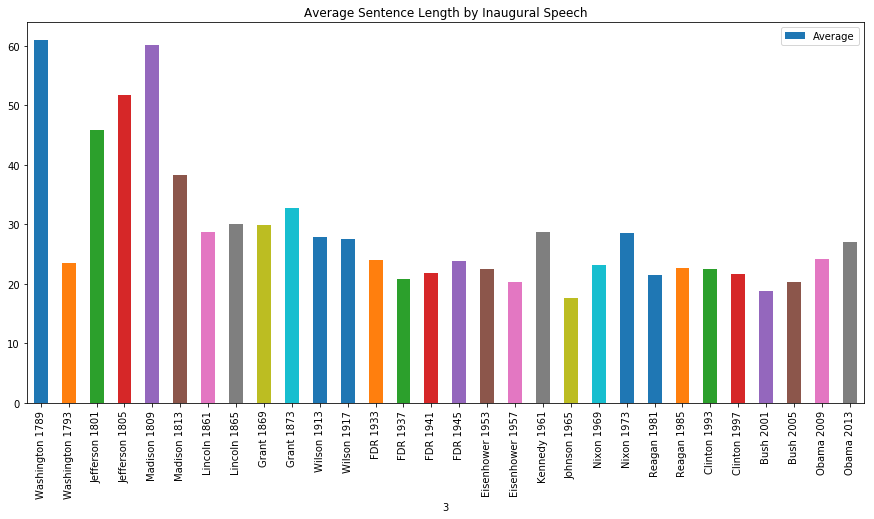

In [11]:
avg_sent_by_pres.plot(y='Average', kind='bar', figsize=(15,7), title="Average Sentence Length by Inaugural Speech")
plt.show()

In [12]:
similarity_df = pd.DataFrame(data=pres, columns=['Speech'],
                             index=pres_df[3].unique())

In [13]:
similarity_df['Speech_length'] = similarity_df['Speech'].map(lambda x: len(x))

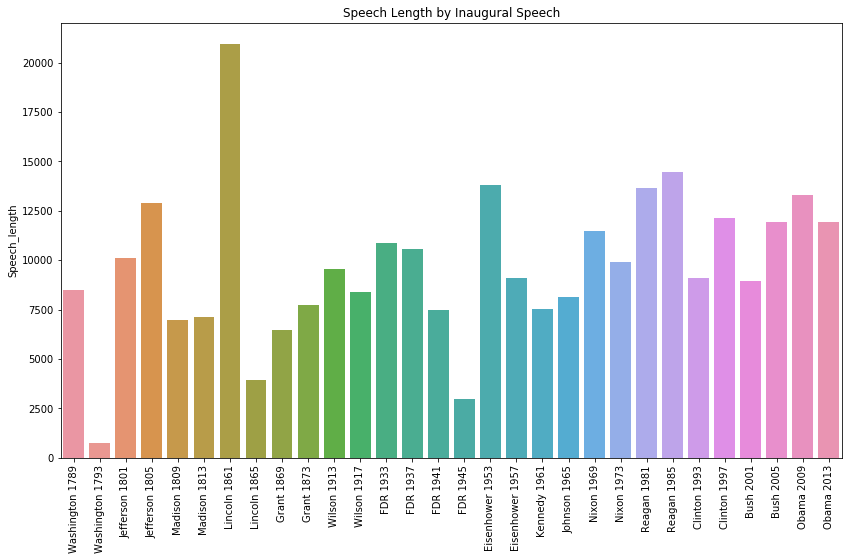

In [14]:
plt.figure(figsize=(14,8))
sns.barplot(x=similarity_df.index, y=similarity_df['Speech_length'])
plt.title("Speech Length by Inaugural Speech")
plt.xticks(rotation=90)
plt.show()

In [17]:
#Getting the top occurring words in the corpus
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_sents = count_vectorizer.fit_transform(text_data.as_matrix())
    
    vectorized_total = np.sum(vectorized_sents, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_sents.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

word_counts = {}

count_vectorizer = CountVectorizer(stop_words='english', min_df=1)

In [19]:
PYTHONIOENCODING='utf-8'
def get_counts(df):
    counts = {}
    for i in pres_df[1].unique():
        words, word_values = get_top_n_words(n_top_words=20, count_vectorizer=count_vectorizer, text_data=df[df[1]==i][0].astype(str))
        counts[i] = words
    return counts
word_counts = get_counts(pres_df)

C:\Users\sohai\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\sohai\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Top Words by All Presidents')

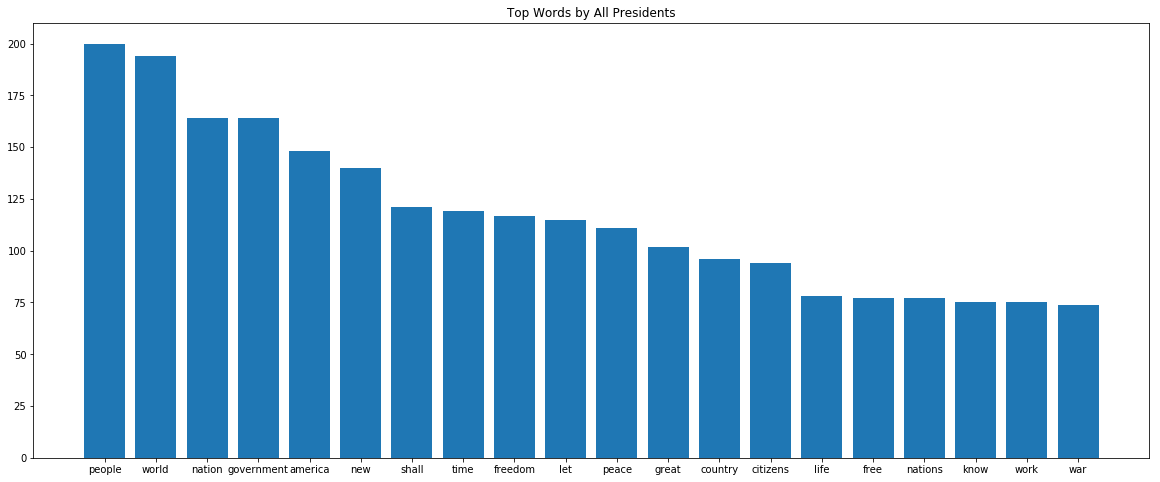

In [20]:
words, word_values = get_top_n_words(n_top_words=20, count_vectorizer=count_vectorizer, text_data=pres_df[0].astype(str))
#Try doing this with lemmas
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words)
ax.set_title('Top Words by All Presidents')

## Most common words for each president

In [21]:
pres_word_counts = pd.DataFrame.from_dict(word_counts, orient='index')
pres_word_counts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
George Washington,government,citizens,present,shall,country,public,united,people,duty,ought,fellow,measures,official,good,hand,subject,far,voice,confidence,happiness
Thomas Jefferson,public,citizens,government,fellow,shall,state,let,peace,good,man,constitution,country,power,law,opinion,principle,reason,safety,principles,duties
James Madison,war,country,public,states,united,nations,spirit,nation,rights,justice,long,british,citizens,confidence,resources,support,people,peace,honorable,sense
Abraham Lincoln,constitution,union,shall,people,states,government,war,law,right,national,case,laws,state,constitutional,years,authority,make,time,citizens,minority
Ulysses S. Grant,country,best,office,people,great,government,nation,laws,public,good,question,years,states,subject,dollar,far,commerce,nations,territory,support
Woodrow Wilson,great,shall,men,life,things,nation,purpose,justice,government,world,thought,new,people,counsel,set,action,duty,industrial,party,peace
Franklin Delano Roosevelt,people,nation,government,shall,democracy,men,life,know,spirit,new,national,years,world,good,way,states,peace,great,united,today
Dwight D. Eisenhower,world,free,peace,freedom,nations,people,shall,strength,faith,know,peoples,men,hope,seek,help,life,time,power,common,country
John F. Kennedy,let,world,sides,pledge,new,shall,citizens,power,ask,free,nations,hope,man,country,americans,fellow,help,war,peace,president
Lyndon B. Johnson,change,nation,man,union,people,world,old,justice,liberty,land,american,covenant,great,new,believe,way,time,day,generation,faith


# Implementing bag of words along with punctuation counts

In [22]:
def bag_of_words(text):
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop
                and not token.is_space]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(350)]
    
def bow_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['President'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and not token.is_space
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
            
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [23]:
wash_words = bag_of_words(washington_1789_doc) + bag_of_words(washington_1793_doc)
jefferson_words = bag_of_words(jefferson_1801_doc) + bag_of_words(jefferson_1805_doc)
madison_words = bag_of_words(madison_1809_doc) + bag_of_words(madison_1813_doc)
lincoln_words = bag_of_words(lincoln_1861_doc) + bag_of_words(lincoln_1865_doc)
grant_words = bag_of_words(grant_1869_doc) + bag_of_words(grant_1873_doc)
wilson_words = bag_of_words(wilson_1913_doc) + bag_of_words(wilson_1917_doc)
fdr_words = bag_of_words(fdr_1933_doc) + bag_of_words(fdr_1937_doc) + bag_of_words(fdr_1941_doc) + bag_of_words(fdr_1945_doc)
eisenhower_words = bag_of_words(eisenhower_1953_doc) + bag_of_words(eisenhower_1957_doc)
kennedy_words = bag_of_words(kennedy_1961_doc) 
johnson_words = bag_of_words(johnson_1965_doc)
nixon_words = bag_of_words(nixon_1969_doc) + bag_of_words(nixon_1973_doc)
reagan_words = bag_of_words(reagan_1981_doc) + bag_of_words(reagan_1985_doc)
clinton_words = bag_of_words(clinton_1993_doc) + bag_of_words(clinton_1997_doc)
bush_words = bag_of_words(bush_2001_doc) + bag_of_words(bush_2005_doc)
obama_words = bag_of_words(obama_2009_doc) + bag_of_words(obama_2013_doc)

#Wordset for all unique words used by all the authors
common_words = set(wash_words+jefferson_words+madison_words+lincoln_words+grant_words+wilson_words+fdr_words+eisenhower_words
                   +kennedy_words+johnson_words+nixon_words+reagan_words+clinton_words+bush_words+obama_words)
len(common_words)

3252

In [24]:
bow_feats = bow_features(pres_df, common_words)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000


In [25]:
print(bow_feats.shape)
bow_feats.head()

(2231, 3254)


,skin,anybody,peace,ignorance,lawful,priority,false,exceed,countrymen,incomparably,...,shout,intention,predecessor,impression,insistence,constitutional,industrialist,feed,text_sentence,President
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Fellow, Citizens, of, the, Senate, and, of, t...",George Washington
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Among, the, vicissitudes, incident, to, life,...",George Washington
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(On, the, one, hand, ,, I, was, summoned, by, ...",George Washington
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(On, the, other, hand, ,, the, magnitude, and,...",George Washington
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(In, this, conflict, of, emotions, all, I, dar...",George Washington


In [26]:
bow_data = pd.concat([bow_feats, pres_df[[2,3,4, 'Sentence_len']]], 1)

# Making tf_idf matrix

In [27]:
vectorizer = TfidfVectorizer(max_df=0.55, # drop words that occur in more than 65% of the sentences
                             min_df=2, # use all words that appear at least once
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True, #using inverse term frequency
                             norm=u'l2', 
                             smooth_idf=True, #avoiding divide by 0 errors
                            )

In [28]:
#transforming the text data into vector format
pres_tf_idf = vectorizer.fit_transform(pres_df[0].astype(str))
tfidf_csr = pres_tf_idf.tocsr() 

In [29]:
full_sents = [[sent] for sent in pres_df[0]]

In [30]:
n = tfidf_csr.shape[0]
#A list of dictionaries, one per sentence
tfidf_bysent = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()
#for each sentence, lists the feature words and their tf-idf scores
for i, j in zip(*tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = tfidf_csr[i, j]

print('Original sentence:', full_sents[2])
print('Tf_idf vector:', tfidf_bysent[2])

Original sentence: [On the one hand, I was summoned by my Country, whose voice I can never hear but with veneration and love, from a retreat which I had chosen with the fondest predilection, and, in my flattering hopes, with an immutable decision, as the asylum of my declining years a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination, and of frequent interruptions in my health to the gradual waste committed on it by time.]
Tf_idf vector: {'day': 0.15054502416818891, 'hand': 0.1851540589045142, 'summoned': 0.21796246065096248, 'country': 0.13128221666539502, 'voice': 0.19612659089342679, 'hear': 0.2131063287035968, 'love': 0.17849729396727154, 'retreat': 0.41779951174443264, 'chosen': 0.19612659089342679, 'hopes': 0.17849729396727154, 'immutable': 0.23979833040849818, 'decision': 0.2131063287035968, 'years': 0.14290372594755896, 'rendered': 0.2237060456785, 'necessary': 0.1851540589045142, 'dear': 0.23979833040849818, 

In [31]:
tf_data = pd.DataFrame(pres_tf_idf.toarray(), index=pres_df.index, columns=terms)

tf_component = pd.concat([tf_data, pres_df], 1)

In [32]:
tf_component.shape
tf_component.head()

,1776,1787,1789,1980,19th,200th,20th,21st,30,50,...,yielding,young,youth,zeal,0,1,2,3,4,Sentence_len
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"(Fellow, Citizens, of, the, Senate, and, of, t...",George Washington,Other,Washington 1789,Pre Civil-War era,12
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"(Among, the, vicissitudes, incident, to, life,...",George Washington,Other,Washington 1789,Pre Civil-War era,38
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"(On, the, one, hand, ,, I, was, summoned, by, ...",George Washington,Other,Washington 1789,Pre Civil-War era,96
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"(On, the, other, hand, ,, the, magnitude, and,...",George Washington,Other,Washington 1789,Pre Civil-War era,60
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,"(In, this, conflict, of, emotions, all, I, dar...",George Washington,Other,Washington 1789,Pre Civil-War era,35


# Clustering by president
## BoW data

In [33]:
X = np.array(bow_data.drop(['text_sentence', 'President', 2, 3, 4], 1))
Y = bow_data['President']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=0, stratify=Y)
index = [['Bag of Words', 'Bag of Words', 'Tf-Idf', 'Tf-Idf'], ['K-Means', 'Spectral Clustering', 'K-Means', 'Spectral Clustering']]
cluster_results_pres = pd.DataFrame(index=index, columns=['ARI score', 'Silhouette Score'])

## K means

In [34]:
true_k = 15
km = cluster.KMeans(n_clusters=true_k, init='k-means++', max_iter=100, random_state=0)
km.fit(X_train)

km_test = km.predict(X_test)

In [35]:
ARI = metrics.adjusted_rand_score(Y_train, km.labels_)
silhouette = metrics.silhouette_score(X_train, km.labels_)
print("Adjusted Rand-Index: %.3f" % ARI )
print("Silhouette Coefficient: %0.3f"
      % silhouette)
cluster_results_pres.iloc[0] = [ARI, silhouette]
# Clusters seem to overlap, but at least they are moving towards homogeneity

Adjusted Rand-Index: 0.011
Silhouette Coefficient: 0.237


In [36]:
cluster_results_pres

ARI score Silhouette Score
Bag of Words K-Means              0.0114574         0.237157
             Spectral Clustering        NaN              NaN
Tf-Idf       K-Means                    NaN              NaN
             Spectral Clustering        NaN              NaN

In [37]:
pd.crosstab(Y_train, km.labels_)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
President,,,,,,,,,,,,,,,
Abraham Lincoln,17,17,0,15,7,0,0,0,7,15,12,13,15,6,0
Barack Obama,14,5,0,25,6,0,1,0,14,26,21,14,22,1,0
Bill Clinton,24,6,0,15,2,0,0,0,11,22,8,25,30,3,0
Dwight D. Eisenhower,27,6,0,24,1,0,0,0,12,23,12,26,29,0,0
Franklin Delano Roosevelt,28,11,0,22,3,0,0,0,17,38,16,37,35,1,0
George W. Bush,27,2,0,19,1,0,0,0,14,29,6,25,36,0,0
George Washington,1,2,0,2,2,0,3,0,1,4,5,1,1,1,0
James Madison,5,8,0,2,4,0,1,1,0,4,10,2,3,1,0
John F. Kennedy,5,3,0,2,3,0,0,0,4,6,6,3,5,3,0


In [38]:
print("Adjusted Rand-Index (Test set): %.3f"
      % metrics.adjusted_rand_score(Y_test, km.predict(X_test)))
print("Silhouette Coefficient (Test set): %0.3f"
      % metrics.silhouette_score(X_test, km.predict(X_test)))

Adjusted Rand-Index (Test set): 0.009
Silhouette Coefficient (Test set): 0.238


In [39]:
pd.crosstab(Y_test, km_test)

col_0,0,1,3,4,5,6,8,9,10,11,12,13,14
President,,,,,,,,,,,,,
Abraham Lincoln,3,2,6,1,0,1,4,6,5,3,10,0,0
Barack Obama,6,2,5,2,0,1,4,11,4,8,7,0,0
Bill Clinton,11,1,8,2,0,0,2,11,3,5,6,0,0
Dwight D. Eisenhower,11,1,13,0,0,0,1,7,6,7,8,0,0
Franklin Delano Roosevelt,7,3,6,0,0,0,5,9,9,19,8,3,0
George W. Bush,6,1,5,0,0,0,3,10,7,9,12,0,0
George Washington,0,0,1,1,3,1,0,1,0,0,0,1,0
James Madison,1,3,0,2,0,0,0,3,3,0,0,2,0
John F. Kennedy,0,1,3,0,0,0,1,4,0,3,1,0,0


# Spectral Clustering 

In [40]:
spectral = cluster.SpectralClustering(n_clusters=true_k, random_state=0)
spectral.fit(X_train)

C:\Users\sohai\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=15, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=0)

In [41]:
ARI = metrics.adjusted_rand_score(Y_train, spectral.labels_)
silhouette = metrics.silhouette_score(X_train, spectral.labels_)
print("Adjusted Rand-Index: %.3f" % ARI )
print("Silhouette Coefficient: %0.3f"
      % silhouette)
cluster_results_pres.iloc[1] = [ARI, silhouette]

Adjusted Rand-Index: -0.001
Silhouette Coefficient: -0.114


# Testing clustering on tf_idf on author prediction
## K means clustering

In [42]:
X = np.array(tf_component.drop([0, 1, 2, 3, 4], 1))
Y = tf_component[1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=0, stratify=Y)

In [43]:
km = cluster.KMeans(n_clusters=true_k, init='k-means++', max_iter=100, random_state=0)
km.fit_transform(X_train)

km_test = km.predict(X_test)

In [44]:
ARI = metrics.adjusted_rand_score(Y_train, km.labels_)
silhouette = metrics.silhouette_score(X_train, km.labels_)
print("Adjusted Rand-Index: %.3f" % ARI )
print("Silhouette Coefficient: %0.3f"
      % silhouette)
cluster_results_pres.iloc[2] = [ARI, silhouette]
# A lot of overlapping clusters

Adjusted Rand-Index: 0.014
Silhouette Coefficient: 0.440


In [45]:
pd.crosstab(Y_train, km.labels_)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,,,,,,,,,,,,,,,
Abraham Lincoln,14,11,0,0,15,15,6,0,0,15,7,18,8,0,15
Barack Obama,18,15,1,0,4,34,1,0,0,20,6,16,15,0,19
Bill Clinton,10,27,0,0,5,31,3,0,0,19,2,31,5,0,13
Dwight D. Eisenhower,17,32,0,0,6,24,0,0,0,23,1,28,2,0,27
Franklin Delano Roosevelt,18,39,0,0,8,48,1,0,0,26,3,32,8,0,25
George W. Bush,13,31,0,0,2,32,0,0,0,23,0,38,1,0,19
George Washington,4,2,3,0,1,3,1,0,0,1,2,1,4,0,1
James Madison,4,2,1,0,9,4,1,1,0,1,3,5,6,0,4
John F. Kennedy,3,1,0,0,3,7,3,0,0,6,3,7,3,0,4


In [46]:
#Test statistics evaluation
print("Adjusted Rand-Index (Test set): %.3f"
      % metrics.adjusted_rand_score(Y_test, km.predict(X_test)))
print("Silhouette Coefficient (Test set): %0.3f"
      % metrics.silhouette_score(X_test, km.predict(X_test)))

Adjusted Rand-Index (Test set): 0.011
Silhouette Coefficient (Test set): 0.437


In [47]:
pd.crosstab(Y_test, km.predict(X_test))

col_0,0,1,2,4,5,6,8,9,10,11,12,13,14
1,,,,,,,,,,,,,
Abraham Lincoln,4,1,1,2,10,0,0,7,1,7,1,0,7
Barack Obama,3,13,1,2,10,0,0,4,2,6,3,0,6
Bill Clinton,4,8,0,2,9,0,0,3,1,13,1,0,8
Dwight D. Eisenhower,10,9,0,1,6,0,0,4,0,12,3,0,9
Franklin Delano Roosevelt,8,16,0,2,6,3,0,12,0,9,6,0,7
George W. Bush,8,9,0,0,15,0,0,5,0,9,3,0,4
George Washington,1,0,1,0,1,1,0,0,1,0,0,3,0
James Madison,1,1,0,3,2,2,0,0,2,0,2,0,1
John F. Kennedy,0,1,0,1,3,0,0,3,0,0,0,0,5


# Spectral Clustering 

In [48]:
true_k=15
spectral = cluster.SpectralClustering(n_clusters=true_k, random_state=0)
spectral.fit(X_train)

C:\Users\sohai\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=15, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=0)

In [49]:
ARI = metrics.adjusted_rand_score(Y_train, spectral.labels_)
silhouette = metrics.silhouette_score(X_train, spectral.labels_)
print("Adjusted Rand-Index: %.3f" % ARI )
print("Silhouette Coefficient: %0.3f"
      % silhouette)
cluster_results_pres.iloc[3] = [ARI, silhouette]

Adjusted Rand-Index: 0.011
Silhouette Coefficient: 0.280


In [50]:
cluster_results_pres

ARI score Silhouette Score
Bag of Words K-Means              0.0114574         0.237157
             Spectral Clustering -0.0005647        -0.113605
Tf-Idf       K-Means              0.0136188         0.440441
             Spectral Clustering  0.0114162          0.27976

## Analyzing the results of clustering

We see here that the clustering of the documents by president does not perform too well. In fact, according to the ARI score, which measures the level of agreement in the assigned clusters to the ground truth, we see that our model clusters almost at random. And the low silhouette score shows that the clusters are not evenly sized and may have quite a few overlapping clusters. The biggest problem for the model is the lack of data. Some presidents only gave one inaugural speech, so that's not a lot of information for the model to discriminate documents well. A better way to improve this would to have a larger corpus from each person listed and then remodel. Another potential setback for the model is the fact that inaugural speeches tend to have a structure that is repeated from president to president. Lot's of phrases are repeated such as 'God Bless America' or 'My Fellow Americans' that without enough data, the model can have a tough time discerning different sentences which could potentially be attributed to multiple presidents. 

# Clustering by time period
## BoW data

In [51]:
cluster_results = pd.DataFrame(index=index, columns=['ARI score', 'Silhouette Score'])

In [52]:
X = np.array(bow_data.drop(['text_sentence', 'President', 2, 3, 4], 1))
Y = bow_data[4]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=0, stratify=Y)

## K means clustering

In [53]:
true_k=3
km = cluster.KMeans(n_clusters=true_k, init='k-means++', max_iter=100, random_state=0)
km.fit(X_train)

km_test = km.predict(X_test)

In [54]:
ARI = metrics.adjusted_rand_score(Y_train, km.labels_)
silhouette = metrics.silhouette_score(X_train, km.labels_)
print("Adjusted Rand-Index: %.3f" % ARI )
print("Silhouette Coefficient: %0.3f"
      % silhouette)
cluster_results.iloc[0] = [ARI, silhouette]
# Clusters seem to overlap, but at least they are moving towards homogeneity

Adjusted Rand-Index: 0.121
Silhouette Coefficient: 0.619


In [55]:
pd.crosstab(Y_train, km.labels_)

col_0,0,1,2
4,,,
Post Civil-War era,302,83,3
Post World Wars,914,136,0
Pre Civil-War era,127,105,3


In [56]:
print("Adjusted Rand-Index (Test set): %.3f"
      % metrics.adjusted_rand_score(Y_test, km.predict(X_test)))
print("Silhouette Coefficient (Test set): %0.3f"
      % metrics.silhouette_score(X_test, km.predict(X_test)))

Adjusted Rand-Index (Test set): 0.076
Silhouette Coefficient (Test set): 0.588


In [57]:
pd.crosstab(Y_test, km_test)

col_0,0,1,2
4,,,
Post Civil-War era,102,27,0
Post World Wars,304,47,0
Pre Civil-War era,52,25,1


# Spectral Clustering 

In [58]:
spectral = cluster.SpectralClustering(n_clusters=true_k, random_state=0)
spectral.fit(X_train)

C:\Users\sohai\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
          eigen_solver=None, eigen_tol=0.0, gamma=1.0, kernel_params=None,
          n_clusters=3, n_init=10, n_jobs=1, n_neighbors=10,
          random_state=0)

In [59]:
ARI = metrics.adjusted_rand_score(Y_train, spectral.labels_)
silhouette = metrics.silhouette_score(X_train, spectral.labels_)
print("Adjusted Rand-Index: %.3f" % ARI )
print("Silhouette Coefficient: %0.3f"
      % silhouette)
cluster_results.iloc[1] = [ARI, silhouette]

Adjusted Rand-Index: -0.010
Silhouette Coefficient: -0.055


# Testing clustering on tf_idf on time period prediction
## K means clustering

In [60]:
X = np.array(tf_component.drop([0, 1, 2, 3, 4], 1))
Y = tf_component[4]
true_k=3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=0, stratify=Y)

In [61]:
km = cluster.KMeans(n_clusters=true_k, init='k-means++', max_iter=100, random_state=0)
km.fit_transform(X_train)

km_test = km.predict(X_test)

In [62]:
ARI = metrics.adjusted_rand_score(Y_train, km.labels_)
silhouette = metrics.silhouette_score(X_train, km.labels_)
print("Adjusted Rand-Index: %.3f" % ARI )
print("Silhouette Coefficient: %0.3f"
      % silhouette)
cluster_results.iloc[2] = [ARI, silhouette]
# A lot of overlapping clusters

Adjusted Rand-Index: 0.121
Silhouette Coefficient: 0.651


In [63]:
pd.crosstab(Y_train, km.labels_)

col_0,0,1,2
4,,,
Post Civil-War era,307,78,3
Post World Wars,921,129,0
Pre Civil-War era,129,103,3


In [64]:
#Test statistics evaluation
print("Adjusted Rand-Index (Test set): %.3f"
      % metrics.adjusted_rand_score(Y_test, km.predict(X_test)))
print("Silhouette Coefficient (Test set): %0.3f"
      % metrics.silhouette_score(X_test, km.predict(X_test)))

Adjusted Rand-Index (Test set): 0.072
Silhouette Coefficient (Test set): 0.623


# Spectral Clustering 

In [68]:
np.linalg.eigvals(X_train)

LinAlgError: Last 2 dimensions of the array must be square

In [65]:
spectral = cluster.SpectralClustering(n_clusters=true_k, random_state=0)
spectral.fit(X_train, Y_train)

C:\Users\sohai\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


LinAlgError: 3-th leading minor of the array is not positive definite

In [ ]:
ARI = metrics.adjusted_rand_score(Y_train, spectral.labels_)
silhouette = metrics.silhouette_score(X_train, spectral.labels_)
print("Adjusted Rand-Index: %.3f" % ARI )
print("Silhouette Coefficient: %0.3f"
      % silhouette)
cluster_results.iloc[3] = [ARI, silhouette]

In [ ]:
cluster_results
#LSTM for neural networks, gives context to make results more accurate

# Initial model testing for BoW
* Random Forest
* Naive Bayes
* Linear SVC
* Logistic regression

## Random Forest

In [69]:
X = np.array(bow_data.drop(['text_sentence', 'President', 2, 3, 4], 1))
Y = bow_data[4]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=0, stratify=Y)

In [70]:
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier(warm_start=True)

rfc.fit(X_train, Y_train)

print("25% holdout score: ", rfc.score(X_test, Y_test))

25% holdout score:  0.677419354839


In [71]:
rf_cross = cross_val_score(rfc, X, Y, cv=7)
print("Cross validation score (avg): ", rf_cross.mean(), "+-", rf_cross.std())

Cross validation score (avg):  0.647672727865 +- 0.0196380717811


## Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, solver='lbfgs', multi_class='multinomial', class_weight='balanced')
lr.fit(X_train, Y_train)

print("25% holdout score: ", lr.score(X_test, Y_test))

25% holdout score:  0.698924731183


In [73]:
lr_cross = cross_val_score(lr, X, Y, cv=7)
print("Cross validation score (avg): ", lr_cross.mean(), "+-", lr_cross.std())


Cross validation score (avg):  0.628448477939 +- 0.0320757700867


In [74]:
pd.crosstab(Y_test, lr.predict(X_test))

col_0,Post Civil-War era,Post World Wars,Pre Civil-War era
4,,,
Post Civil-War era,53,60,16
Post World Wars,57,285,9
Pre Civil-War era,11,15,52


## Linear SVC

In [75]:
from sklearn.svm import LinearSVC

svc = LinearSVC(class_weight='balanced', random_state=16)

svc.fit(X_train, Y_train)

print("25% holdout score: ", svc.score(X_test, Y_test))

25% holdout score:  0.709677419355


In [76]:
svc_cross = cross_val_score(svc, X, Y, cv=7)
print("Cross validation score (avg): ", svc_cross.mean(), "+-", svc_cross.std())

Cross validation score (avg):  0.653977448233 +- 0.0494386035738


In [77]:
pd.crosstab(Y_test, svc.predict(X_test))

col_0,Post Civil-War era,Post World Wars,Pre Civil-War era
4,,,
Post Civil-War era,60,54,15
Post World Wars,45,288,18
Pre Civil-War era,4,26,48


## Naive Bayes

In [78]:
from sklearn import naive_bayes

naive = naive_bayes.MultinomialNB(alpha=.58)

naive.fit(X_train, Y_train)

print("25% holdout score: ", naive.score(X_test, Y_test))

25% holdout score:  0.758064516129


In [79]:
nb_cross = cross_val_score(naive, X, Y, cv=7)
print("Cross validation score (avg): ", nb_cross.mean(), "+-", nb_cross.std())
nb_cross

Cross validation score (avg):  0.710395595152 +- 0.0418993419047


array([ 0.671875  ,  0.70219436,  0.73981191,  0.76489028,  0.76175549,
        0.67924528,  0.65299685])

In [80]:
pd.crosstab(Y_test, naive.predict(X_test))

col_0,Post Civil-War era,Post World Wars,Pre Civil-War era
4,,,
Post Civil-War era,47,66,16
Post World Wars,23,320,8
Pre Civil-War era,9,13,56


# Evaluating BoW approach

* The Naive Bayes classifier performs the best in both the test set and the cross validation, making it the most consistent classifier. 
* Linear SVC and Logistic Regression also good choice
* SVC better for when the sample and feature spase starts to get really large
* Random forest performs efficiently and is very lenient on input
* Post Civil war era and Post World Wars era seem to have the most overlap

# Testing tf-idf model
## Random Forest

In [81]:
X = np.array(tf_component.drop([0, 1, 2, 3, 4], 1))
Y = tf_component[4] #time period

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25, random_state=0, stratify=Y)

In [82]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, Y_train)

print("25% holdout score: ", rfc.score(X_test, Y_test))

25% holdout score:  0.648745519713


In [83]:
rf_cross = cross_val_score(rfc, X, Y, cv=7)
print("Cross validation score (avg): ", rf_cross.mean(), "+-", rf_cross.std())

Cross validation score (avg):  0.631104454945 +- 0.0199848443538


## Logistic Regression

In [84]:
lr = LogisticRegression(C=10, solver='lbfgs', multi_class='multinomial', class_weight='balanced')
lr.fit(X_train, Y_train)

print("25% holdout score: ", lr.score(X_test, Y_test))

25% holdout score:  0.722222222222


In [85]:
lr_cross = cross_val_score(lr, X, Y, cv=7)
print("Cross validation score (avg): ", lr_cross.mean(), "+-", lr_cross.std())

Cross validation score (avg):  0.656622132553 +- 0.0468481452963


## Naive Bayes

In [86]:
naive = naive_bayes.MultinomialNB()

naive.fit(X_train, Y_train)

print("25% holdout score: ", naive.score(X_test, Y_test))

25% holdout score:  0.629032258065


In [87]:
nb_cross = cross_val_score(naive, X, Y, cv=7)
print("Cross validation score (avg): ", nb_cross.mean(), "+-", nb_cross.std())

Cross validation score (avg):  0.627521865796 +- 0.000724263266744


## Linear SVC

In [88]:
tf_component.shape

(2231, 2699)

In [89]:
svc = LinearSVC(class_weight='balanced', random_state=16)

svc.fit(X_train, Y_train)

print("25% holdout score: ", svc.score(X_test, Y_test))

25% holdout score:  0.716845878136


In [90]:
svc_cross = cross_val_score(svc, X, Y, cv=7)
print("Cross validation score (avg): ", svc_cross.mean(), "+-", svc_cross.std())

Cross validation score (avg):  0.649863942626 +- 0.0571029687749


# tf_idf evaluation

* The Linear SVC performs the best with tf_idf data
* Previous additions of grammar did not significantly increase gains in accuracy, given how stylystically dense the inaugural 
  speeches are
* Still not as performant as BoW, but it's very close

# calculating similarity between sentences
* First convert sentences to a dense format using LSA so we capture related ideas together
* use tf_idf scores to further calculate similarity between documents (sentences)

## Latent Semantic Analysis

In [107]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

X_train, X_test, Y_train, Y_test = train_test_split(pres_df[0].astype(str), bow_data[4], test_size=0.25, random_state=0)
svd= TruncatedSVD(350)
lsa = make_pipeline(svd, Normalizer(copy=False))

lsa_data = lsa.fit_transform(pres_tf_idf)
X_train_lsa, X_test_lsa = train_test_split(lsa_data, test_size=.25, random_state=0)


variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 54.766784397


In [108]:
X_train, X_test = train_test_split(pres_df[0].astype(str), test_size=.25, random_state=0)

LSA_X_train = pd.DataFrame(X_train_lsa, index=X_train)

In [109]:
k_means = cluster.KMeans(n_clusters=3, init='k-means++', max_iter=100)
k_means.fit(X_train_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [110]:
#Test statistics evaluation
print("Adjusted Rand-Index (Test set): %.3f"
      % metrics.adjusted_rand_score(Y_test, k_means.predict(X_test_lsa)))
print("Silhouette Coefficient (Test set): %0.3f"
      % metrics.silhouette_score(X_test_lsa, k_means.predict(X_test_lsa)))

Adjusted Rand-Index (Test set): -0.030
Silhouette Coefficient (Test set): 0.008


In [111]:
for i in range(10):
    print('Cluster {}:'.format(i))
    print(LSA_X_train.loc[:,i].sort_values(ascending=False)[0:10])

Cluster 0:
0
America stands alone as the world's indispensable nation.                                                                                                              0.462445
In America¡                                                                                                                                                            0.439277
America¡                                                                                                                                                               0.439277
In America¡                                                                                                                                                            0.439277
America¡                                                                                                                                                               0.439277
America!                                                                                                   

Name: 3, dtype: float64
Cluster 4:
0
As we explore the reaches of space, let us go to the new worlds together not as new worlds to be conquered, but as a new adventure to be shared.                                                                                                                     0.528086
We have been refreshed by a new insight into our own life.                                                                                                                                                                                                           0.527793
With a new vision of government, a new sense of responsibility, a new spirit of community, we will sustain America's journey.                                                                                                                                        0.504146
And we need a new sense of responsibility for a new century.                                                                                             

Name: 6, dtype: float64
Cluster 7:
0
Freedom                                                                                                                                                                                  0.522223
¦s ideal of freedom                                                                                                                                                                      0.383660
¦s ideal of freedom                                                                                                                                                                      0.383660
America must remain freedom's staunchest friend, for freedom is our best ally.                                                                                                           0.377345
Human freedom is on the march, and nowhere more so than our own hemisphere.                                                                                                              0.

make a cosine similarity score for clusters 
affinity propagation

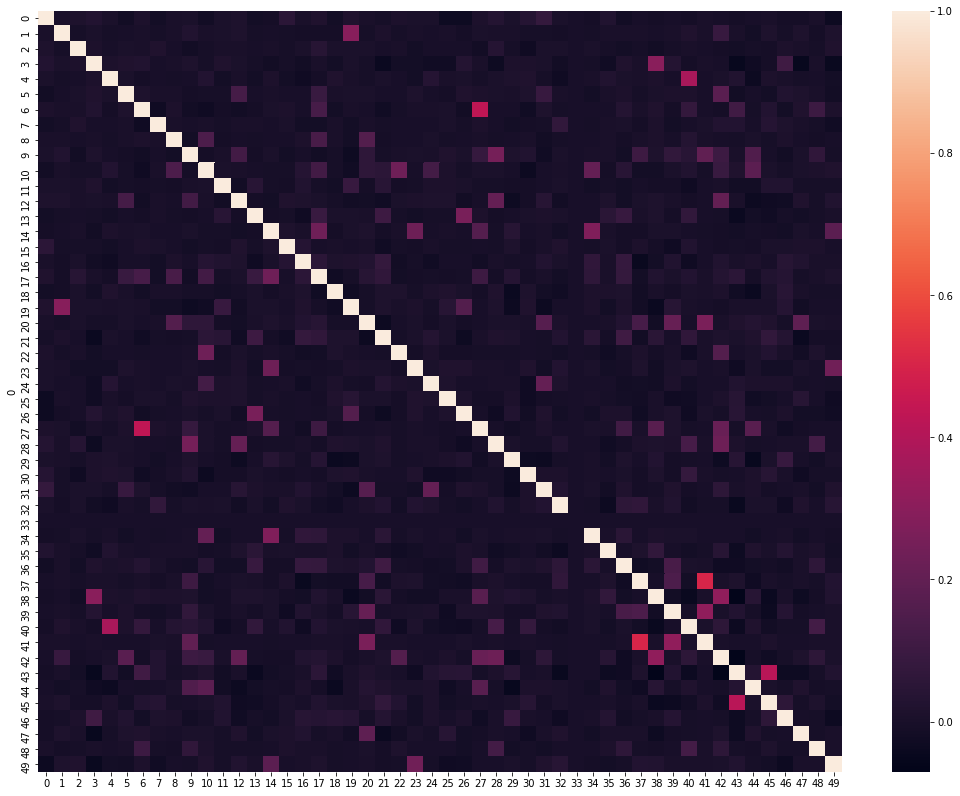

Key:
0 We remain the most prosperous, powerful nation on Earth.
1 Yet his purpose is achieved in our duty, and our duty is fulfilled in service to one another.
2 We are provincials no longer.
3 With which should we be most likely to live in harmony and friendly intercourse?
4 As we measure what can be done, we shall promise only what we know we can produce, but as we chart our goals we shall be lifted by our dreams.
5 Today we reconsecrate our country to long cherished ideals in a suddenly changed civilization.
6 A dynamic economy, with more citizens working and paying taxes, will be our strongest tool to bring down budget deficits.
7 All this will not be finished in the first 100 days.
8 But let us begin.
9 My fellow Americans, as we look back at this remarkable century, we may ask, can we hope not just to follow, but even to surpass the achievements of the 20th century in America and to avoid the awful bloodshed that stained its legacy?
10 To the people of poor nations, we pledge to 

In [112]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:50,0:50]
#Making a plot
plt.figure(figsize=(18,14))
ax = sns.heatmap(sim_matrix,yticklabels=range(50))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(50):
    print(i,sim_matrix.index[i])

## What patterns have we learned from LSA

Inaugural speeches tend to have a pattern to them, as seen by the most common words of each president as well as the results from LSA. We see that some common themes are repeated by the presidents across the ages. Inaugural speeches includes concepts mentioning the government and its relationsip with the people, describing the people of the United States, refereeing to the audience as 'us', describing the Nation as strong/peaceful/diverse, engaging in the 'we shall' speech, and mentioning the Constitution. These ideas and variations of them are onstantly repeated by the presidents as a way to capture the masses and cast a wide net to please as many people as possible. There is also a large focus on the goverment preserving the nation, fostering peace, and making sure that the people of the US are understood. 

## How similar are the presidential speeches to each other

In [113]:
speech_tfidf = vectorizer.fit_transform(similarity_df['Speech'].astype(str))

speech_df = pd.DataFrame(speech_tfidf.toarray(), columns=vectorizer.get_feature_names(), index=similarity_df.index)

In [114]:
speech_similarity = pd.concat([speech_df, similarity_df], 1)


lsa_data_speech = lsa.fit_transform(speech_tfidf)

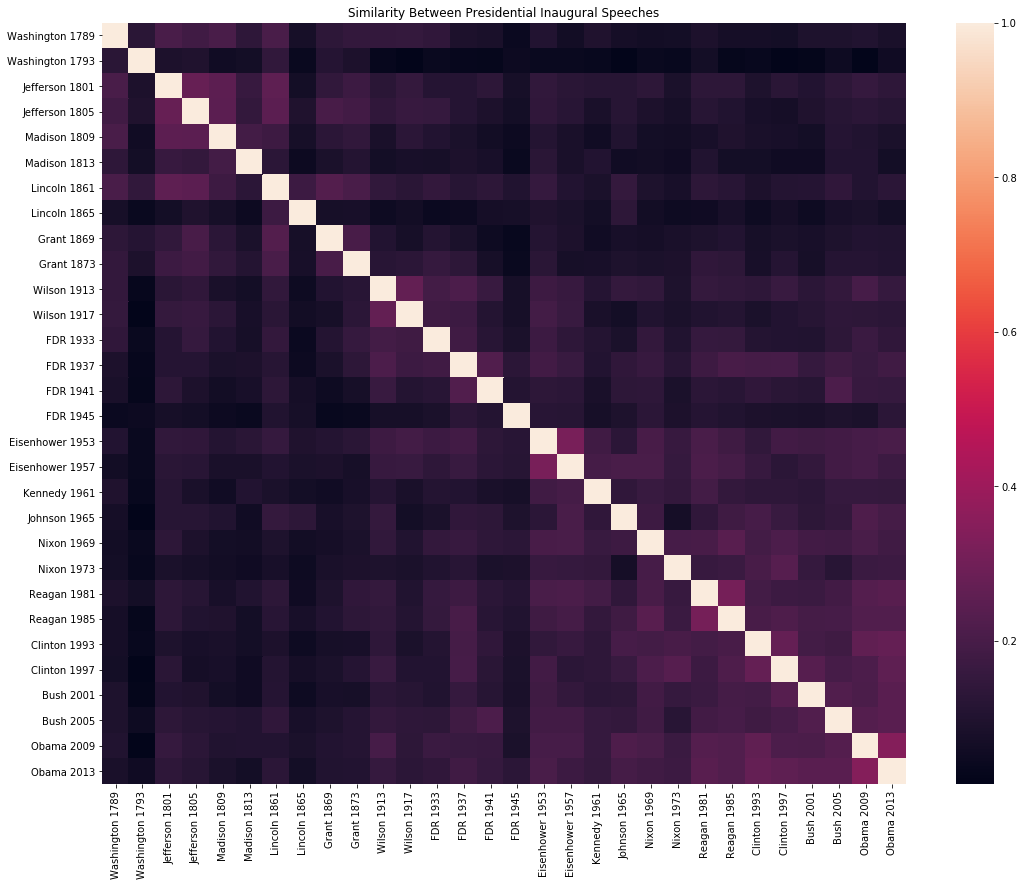

In [115]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(lsa_data_speech) * np.asmatrix(lsa_data_speech).T)

sim_matrix=pd.DataFrame(similarity,index=speech_df)
#Making a plot
plt.figure(figsize=(18,14))
ax = sns.heatmap(sim_matrix,yticklabels=speech_df.index, xticklabels=speech_df.index)
plt.title("Similarity Between Presidential Inaugural Speeches")
plt.show()

#try to cluster and predict time period

# Testing LSA model
## Random Forest

In [116]:
Y = tf_component[4] #time period

Y_train, Y_test = train_test_split(Y, test_size=.25, random_state=0, stratify=Y)

In [117]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train_lsa, Y_train)

print("25% holdout score: ", rfc.score(X_test_lsa, Y_test))

25% holdout score:  0.575268817204


In [118]:
rf_cross = cross_val_score(rfc, lsa_data, Y, cv=7)
print("Cross validation score (avg): ", rf_cross.mean(), "+-", rf_cross.std())

Cross validation score (avg):  0.597890205626 +- 0.0322543096684


## Logistic Regression

In [124]:
lr = LogisticRegression(C=10, solver='lbfgs', multi_class='multinomial', class_weight='balanced', random_state=0)
lr.fit(X_train_lsa, Y_train)

print("25% holdout score: ", lr.score(X_test_lsa, Y_test))

25% holdout score:  0.399641577061


In [125]:
lr_cross = cross_val_score(lr, lsa_data, Y, cv=7)
print("Cross validation score (avg): ", lr_cross.mean(), "+-", lr_cross.std())
lr_cross

Cross validation score (avg):  0.604675144605 +- 0.0535295197379


array([ 0.515625  ,  0.59561129,  0.63949843,  0.60188088,  0.70532915,
        0.59433962,  0.58044164])

## Linear SVC

In [121]:
svc = LinearSVC(class_weight='balanced', random_state=16)

svc.fit(X_train_lsa, Y_train)

print("25% holdout score: ", svc.score(X_test_lsa, Y_test))

25% holdout score:  0.492831541219


In [126]:
svc_cross = cross_val_score(svc, lsa_data, Y, cv=7)
print("Cross validation score (avg): ", svc_cross.mean(), "+-", svc_cross.std())
svc_cross

Cross validation score (avg):  0.649486387228 +- 0.0477924017419


array([ 0.571875  ,  0.63949843,  0.68025078,  0.6645768 ,  0.73667712,
        0.63207547,  0.6214511 ])

# LSA evaluation

* The Linear SVC performs the best with tf_idf data reduced using LSA
* Naive bayes can't apply here because of negative input created by dimensionality reduction